In [1]:
import logging
import matplotlib.pyplot as plt
import nltk
import pandas as pd
import pandas.util.testing as tm
import re
import seaborn as sns
import warnings

from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models.phrases import Phrases, Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pprint import pprint
from scipy.stats import kruskal, shapiro
from statsmodels.graphics.gofplots import qqplot
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from helpers import (
    get_frequencies_df,
    get_ngrams_freq,
    get_sentiment,
    get_tokens_series,
    lemmatization,
    make_bigrams,
    make_trigrams,
    plot_top_terms_heatmap,
    plot_topics_wordclouds,
    remove_stopwords,
    run_lda_models,
    sent_to_words,
)

%matplotlib inline

# Enable logging for gensim - optional.
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.ERROR)

# Ignore warnings.
warnings.filterwarnings(action='ignore')

/home/iuliana/Anaconda3/envs/ada/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """


In [2]:
%load_ext pycodestyle_magic

In [3]:
# Make sure code follows PEP8 style rules.
%pycodestyle_on

In [4]:
# Data path. Fill in your own.
data_path = './reddit_vm.csv'
myths_df = pd.read_csv(data_path)

# Number of rows and columns.
myths_df.shape

(1487, 8)

# Exploratory Data Analysis

In [5]:
# Inspect the raw data.
myths_df.head(5)

title  score      id  \
0  Health Canada approves AstraZeneca COVID-19 va...      7  lt74vw   
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  lsh0ij   
2  Coronavirus variants could fuel Canada's third...      6  lohlle   
3  Canadian government to extend COVID-19 emergen...      1  lnptv8   
4  Canada: Pfizer is 'extremely committed' to mee...      6  lkslm6   

                                                 url  comms_num       created  \
0  https://www.canadaforums.ca/2021/02/health-can...          0  1.614400e+09   
1  https://www.canadaforums.ca/2021/02/covid-19-i...          1  1.614316e+09   
2  https://www.canadaforums.ca/2021/02/coronaviru...          0  1.613887e+09   
3  https://www.canadaforums.ca/2021/02/canadian-g...          0  1.613796e+09   
4  https://www.canadaforums.ca/2021/02/canada-pfi...          0  1.613468e+09   

  body            timestamp  
0  NaN  2021-02-27 06:33:45  
1  NaN  2021-02-26 07:11:07  
2  NaN  2021-02-21 07:50:08  
3  NaN  2021-02-20 06:35:13  
4  NaN  2021-02-16 11:36:28

In [6]:
# Inspect the raw data.
myths_df.tail(5)

title  score       id  url  comms_num       created  \
1482  Comment      1  ek3q3xm  NaN          0  1.554417e+09   
1483  Comment      0  ek3pc0s  NaN          0  1.554417e+09   
1484  Comment      1  ek37pd4  NaN          0  1.554397e+09   
1485  Comment      1  ek35upu  NaN          0  1.554394e+09   
1486  Comment      1  ek24urf  NaN          0  1.554359e+09   

                                                   body            timestamp  
1482  Basically nothing.\n\n>Autoimmunity to the cen...  2019-04-05 01:32:39  
1483  In this instance, yourself. Broader, that Vaxf...  2019-04-05 01:23:27  
1484  The information I provided is not wrong. It's ...  2019-04-04 20:03:24  
1485  What does this mean?\nhttps://www.ncbi.nlm.nih...  2019-04-04 19:07:42  
1486  Thanks for explaining the issues you saw in my...  2019-04-04 09:16:27

We can see that comments have `Comment` for title.

In [7]:
# Check for NaN values.
myths_df.isnull().sum()

title           0
score           0
id              0
url          1037
comms_num       0
created         0
body          366
timestamp       0
dtype: int64

We are not concerned about the missing URLs since we won't use them, however we must replace the NaN body values corresponding to posts with empty strings.

In [8]:
# Replace NaN values in the `body` column with empty string ''.
# null_body = myths_df.loc[myths_df['body'].isnull(), 'body']
null_body_mask = myths_df['body'].isnull()
myths_df.loc[null_body_mask, ['body']] = (myths_df.loc[null_body_mask, 'body']
                                          .apply(lambda x: ''))

# Check for NaN values.
myths_df.isnull().sum()

title           0
score           0
id              0
url          1037
comms_num       0
created         0
body            0
timestamp       0
dtype: int64

Now there are only URL missing values.

In [9]:
# Replace `Comment` in the title column with empty string ''.
myths_df['title'] = myths_df['title'].apply(
    lambda x: '' if (x.lower() == 'comment') else x
    )

Text(0.5, 1.0, 'Num. of comments distribution')

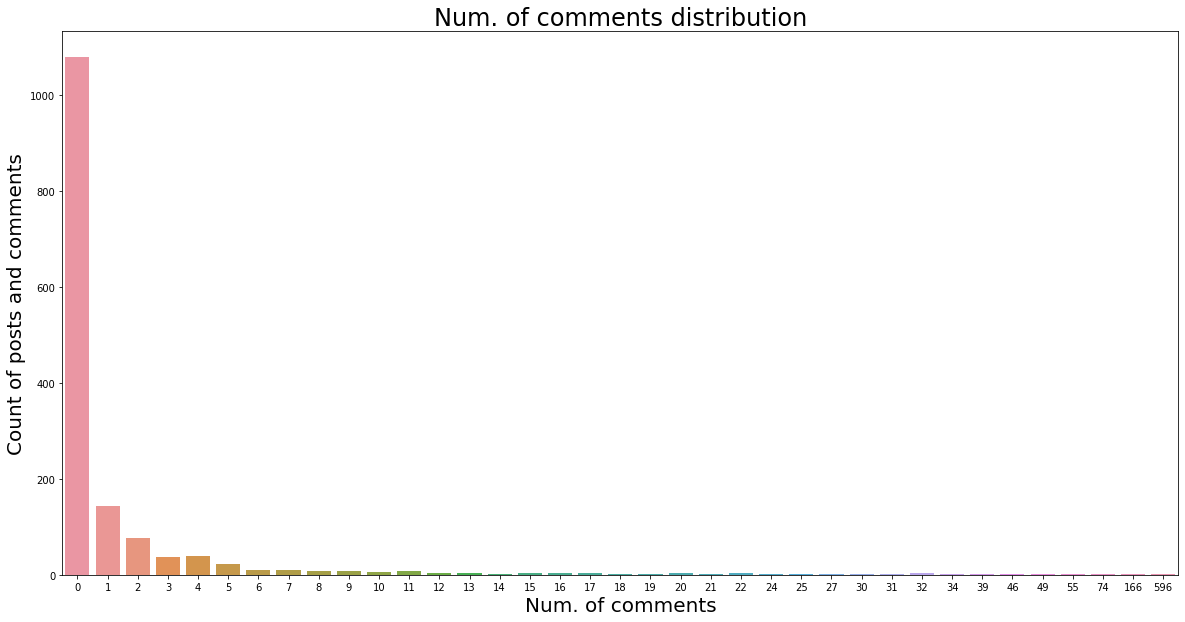

In [10]:
# Visualize the comments number distribution.
comm_num_counts = get_frequencies_df(myths_df['comms_num'].copy(), 'comms_num')

plt.figure(figsize=(20, 10))
sns.barplot(x='comms_num', y='comms_num_count', data=comm_num_counts)
plt.xlabel('Num. of comments', size=20)
plt.ylabel('Count of posts and comments', size=20)
plt.title('Num. of comments distribution', size=24)

We can see that most posts and comments have a rather small number of comments. However, we can see a few outliers which caused a significantly higher number of comments: 166 and 594.

Text(0.5, 1.0, 'Scores distribution')

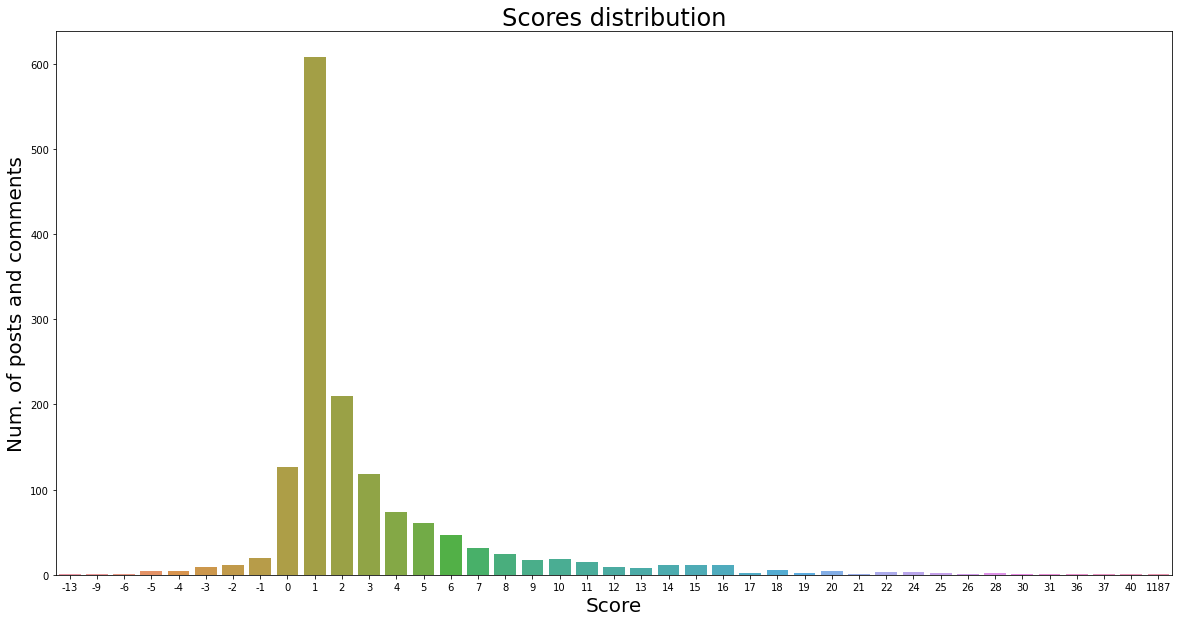

In [11]:
# Visualize the scores distribution.

score_counts = get_frequencies_df(myths_df['score'].copy(), 'score')

plt.figure(figsize=(20, 10))
sns.barplot(x='score', y='score_count', data=score_counts)
plt.xlabel('Score', size=20)
plt.ylabel('Num. of posts and comments', size=20)
plt.title('Scores distribution', size=24)

We can see that most posts and comments have rather neutral or positive scores. However, an outlier stands out which caused a significantly higher number of positive reactions: 1187.

In [12]:
# Get the outlier entry and inspect it.
outlier_df = myths_df[myths_df['score'] == 1187]
outlier_df

title  score      id  \
396  I would rage if this was handed to me...   1187  21zc6n   

                            url  comms_num       created body  \
396  http://m.imgur.com/a/bZDWg        596  1.396435e+09        

               timestamp  
396  2014-04-02 13:32:42

After inspecting the outlier post's URL, it seems that it refers to a user's disgust related to a scandalous anti-vaxxers brochure which is being handed around.

In [13]:
%%html
<a href='http://m.imgur.com/a/bZDWg'>Scandalous brochure link</a>

## Time series analysis

In [14]:
# Convert timestamp to datetime object.
myths_df['timestamp'] = pd.to_datetime(myths_df['timestamp'])

# Store date.
myths_df['date'] = myths_df['timestamp'].dt.date

# Store year.
myths_df['year'] = myths_df['timestamp'].dt.year

Text(0.5, 1.0, 'Num. of posts and comments per day')

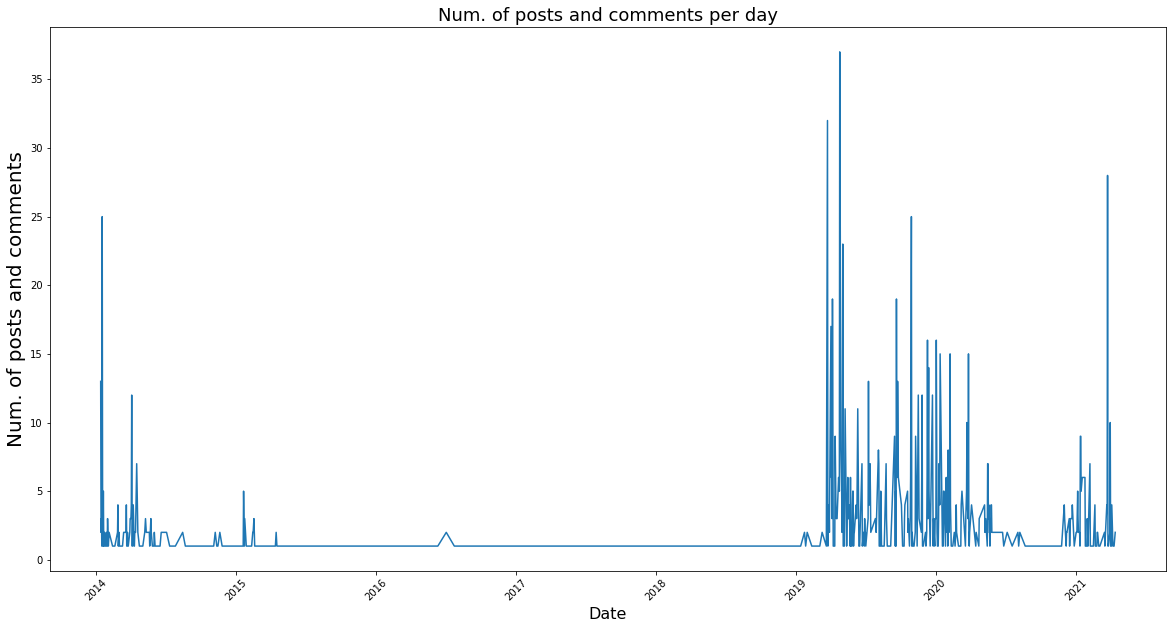

In [15]:
# Group by 'date' in order to count the number of
# comments and posts for each date.
post_comm_per_day = myths_df.groupby('date').size()

# Plot time series.
post_comm_per_day.reset_index().sort_values(
    by='date',
    ascending=True,
    ).plot(figsize=(20, 10), x='date', rot=45, legend=False)

plt.xlabel('Date', size=16)
plt.ylabel('Num. of posts and comments', size=20)
plt.title('Num. of posts and comments per day', size=18)

We can see that people are talking about vaccination and related topics in times when there are certain outbreaks. For example, most likely the peak in 2014 was caused by the Ebola outbreak in Africa, the smaller peak around 2015 was caused by the Zika outbreak in South America, and the final massive peak around 2019 was caused by the COVID-19 global pandemic.

Below, the figure illustrates the yearly trend.

Text(0.5, 1.0, 'Num. of posts and comments per year')

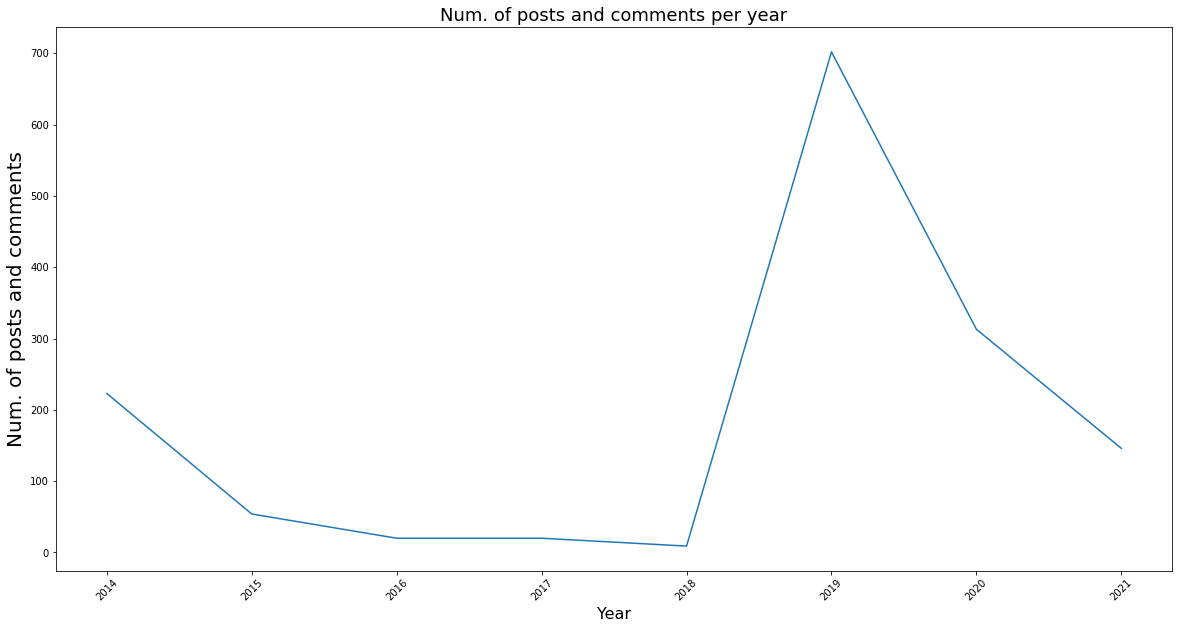

In [16]:
# Group by 'year' in order to count the number of comments
# and posts for each year.
post_comm_per_year = myths_df.groupby('year').size()

# Plot time series.
post_comm_per_year.reset_index().sort_values(
    by='year',
    ascending=True,
    ).plot(figsize=(20, 10), x='year', rot=45,  legend=False)

plt.xlabel('Year', size=16)
plt.ylabel('Num. of posts and comments', size=20)
plt.title('Num. of posts and comments per year', size=18)

Text(0.5, 1.0, 'COVID-19 total no. of posts and comments per day')

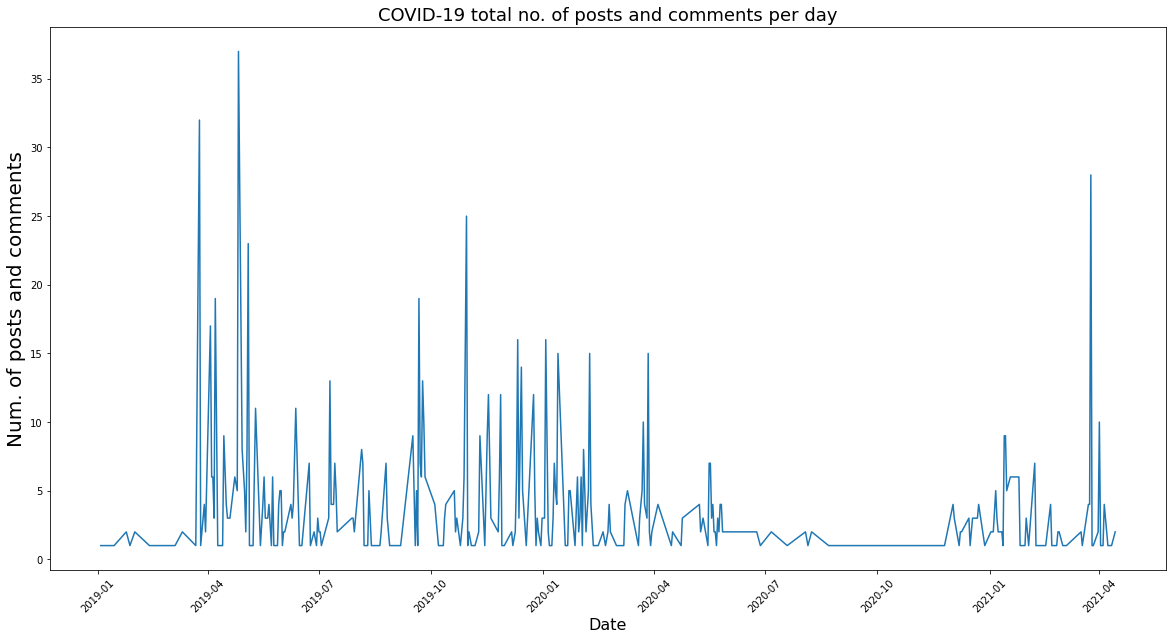

In [17]:
# Get dataframe containing entries from 2019 and later
# i.e. since COVID-19 appeared.
covid_df = myths_df[myths_df['year'] >= 2019].copy()

# Group by 'date' in order to count the number of comments
# and posts for each date.
post_comm_per_day = covid_df.groupby('date').size()

# Plot time series.
post_comm_per_day.reset_index().sort_values(
    by='date',
    ascending=True,
    ).plot(figsize=(20, 10), x='date', rot=45, legend=False)

plt.xlabel('Date', size=16)
plt.ylabel('Num. of posts and comments', size=20)
plt.title('COVID-19 total no. of posts and comments per day', size=18)

We can see how at the beginning of 2019 very few people were active after probably hearing minor news about the Chinese local threat of COVID-19. However, the reddits become much more active as the first wave hits at a global scale and quarantine is pushed through as a primary measure against the disease's further spread. It is also noticeable that during the time between the first and second wave, people were more relaxed in regards to the issue as some measures were temporarily lifted.

# What are the main myths about vaccines?

## Term/token analysis: 

In [18]:
# Concatenate the title and body of each post/comment to obtain
# the full text for analysis.
# Comments' titles are '' and missing posts' bodies are also ''.
myths_df['full_text'] = myths_df.apply(
    lambda x: x['title'] + x['body'], axis=1
    )

# English stop words list.
stop_words = stopwords.words('english')
custom_stop_words = ['vaccine',
                     'vaccines',
                     'vaccination',
                     'vaccinated',
                     'unvaccinated']

# Remove also vaccine-related words since we know
# they are the most frequent in a r/VaccineMyths reddit.
stop_words = stop_words + custom_stop_words

raw_text_series = myths_df['full_text'].copy()
myths_df['tokens'] = get_tokens_series(raw_text_series, stop_words=stop_words)

In [19]:
myths_df.head()

title  score      id  \
0  Health Canada approves AstraZeneca COVID-19 va...      7  lt74vw   
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  lsh0ij   
2  Coronavirus variants could fuel Canada's third...      6  lohlle   
3  Canadian government to extend COVID-19 emergen...      1  lnptv8   
4  Canada: Pfizer is 'extremely committed' to mee...      6  lkslm6   

                                                 url  comms_num       created  \
0  https://www.canadaforums.ca/2021/02/health-can...          0  1.614400e+09   
1  https://www.canadaforums.ca/2021/02/covid-19-i...          1  1.614316e+09   
2  https://www.canadaforums.ca/2021/02/coronaviru...          0  1.613887e+09   
3  https://www.canadaforums.ca/2021/02/canadian-g...          0  1.613796e+09   
4  https://www.canadaforums.ca/2021/02/canada-pfi...          0  1.613468e+09   

  body           timestamp        date  year  \
0      2021-02-27 06:33:45  2021-02-27  2021   
1      2021-02-26 07:11:07  2021-02-26  2021   
2      2021-02-21 07:50:08  2021-02-21  2021   
3      2021-02-20 06:35:13  2021-02-20  2021   
4      2021-02-16 11:36:28  2021-02-16  2021   

                                           full_text  \
0  Health Canada approves AstraZeneca COVID-19 va...   
1  COVID-19 in Canada: 'Vaccination passports' a ...   
2  Coronavirus variants could fuel Canada's third...   
3  Canadian government to extend COVID-19 emergen...   
4  Canada: Pfizer is 'extremely committed' to mee...   

                                              tokens  
0     [health, canada, approves, astrazeneca, covid]  
1     [covid, canada, passport, certainty, ethicist]  
2       [coronavirus, variant, could, canada, third]  
3  [canadian, government, extend, covid, emergenc...  
4  [canada, pfizer, extremely, committed, meeting...

Text(0.5, 1.0, 'Most frequent terms')

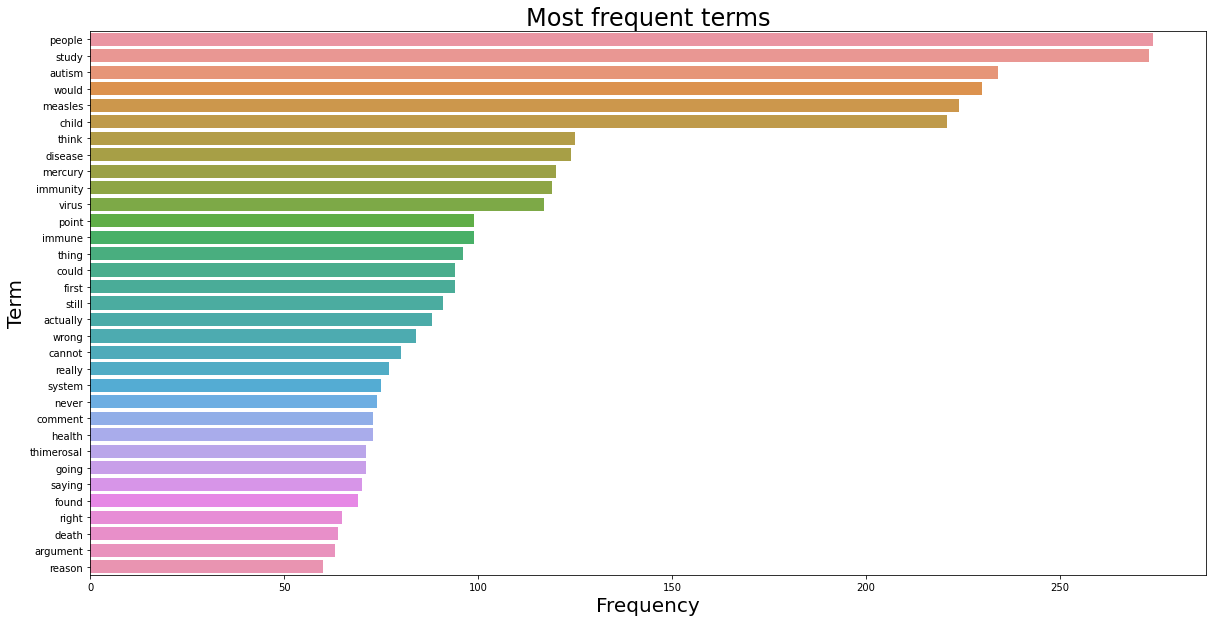

In [20]:
# Visualize most frequent terms.
exploded_tokens_series = myths_df['tokens'].explode().copy()
term_counts = get_frequencies_df(exploded_tokens_series,
                                 label='term',
                                 min_freq=60)

# Plot the top terms frequencies.
plt.figure(figsize=(20, 10))
sns.barplot(y='term', x='term_count', data=term_counts, orient='h')
plt.xlabel('Frequency', size=20)
plt.ylabel('Term', size=20)
plt.title('Most frequent terms', size=24)

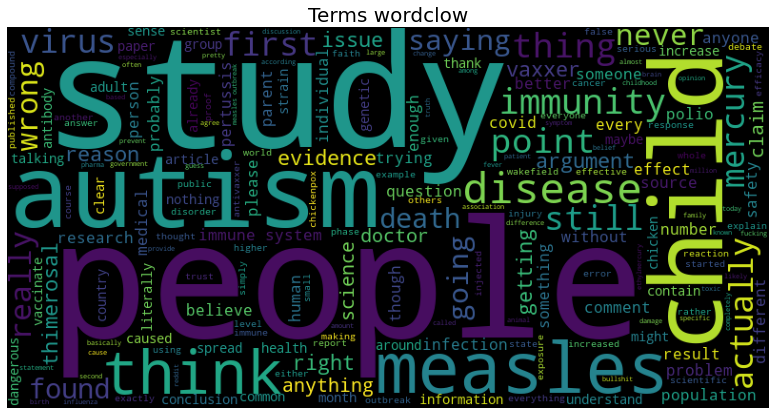

In [21]:
# Generate wordcloud for the unique terms.
wordcloud_title = WordCloud(width=800,
                            height=400,
                            stopwords=STOPWORDS)\
                            .generate(' '.join(myths_df['tokens'].sum()))

# Plot wordclowd.
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('Terms wordclow', size=20)
plt.show()

As expected, both visualizations reveal that the most common term is `vaccine`. We can also see other terms that suggest some vaccination mythis such as: autism, mercury, thimerosal, disease.

In [22]:
# Combine the tokens in each list to get a document
# and store all documents in a list.
docs = myths_df['tokens'].apply(lambda x: ' '.join(x)).tolist()

# Inspect first 3 documents.
docs[:3]

['health canada approves astrazeneca covid',
 'covid canada passport certainty ethicist',
 'coronavirus variant could canada third']

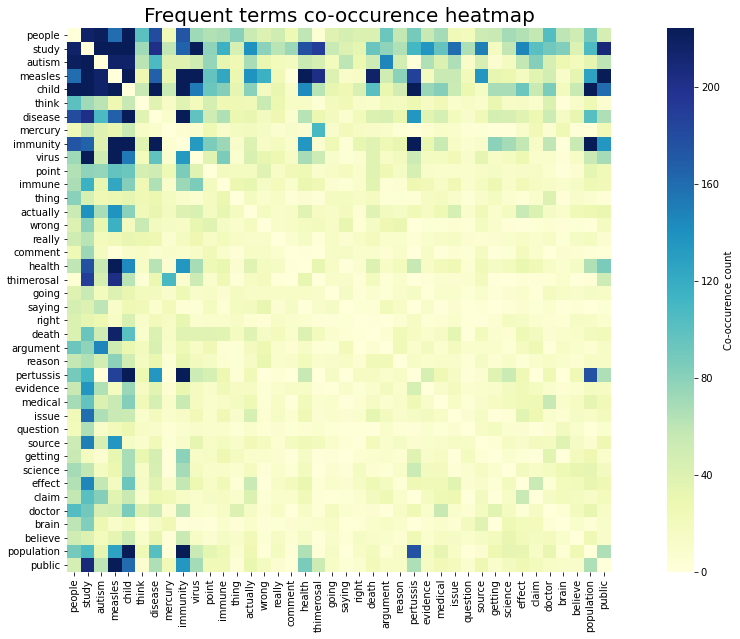

In [23]:
# Visualize co-occurence matrix of top most frequent terms as heatmap.
plot_top_terms_heatmap(docs, myths_df['tokens'].explode().copy())

The heatmap shows the co-occurence scores of the most frequent terms. Unfortunately, this visualization does not provide much insight.

Let us analyse the most frequent bi-grams in the texts.

In [24]:
bigram_freq = get_ngrams_freq(docs, ngram_range=(2, 2))
print('Count - Bi-gram')
for el in bigram_freq.items():
    print('{} -- {}'.format(el[1], el[0]))

Let us analyse the most frequent tri-grams in the texts as well.

In [25]:
trigram_freq = get_ngrams_freq(docs, ngram_range=(3, 3), min_freq=2)
print('Count - Tri-gram')
for el in trigram_freq.items():
    print('{} -- {}'.format(el[1], el[0]))

After analysing the bigrams and trigrams, we can see several myths stand out:  
    - Vaccines cause all sorts of acute neurologiacl issues and brain damage: autism, ADHD, speech disorders, as they pass the blood-brain bareer.  
    - Vaccines cause renal issues.  
    - Vaccines contain all sorts of toxic sustances: mercury, heavy metals, thimerosal.
    - Vaccines infect the person with the disease they try to prevent e.g. measles  
    - It is better to obtain natural immunity to a disease than have a vaccine.  
    - Vaccines alter the immune system.  
    - Vaccines affect pregnant women.  

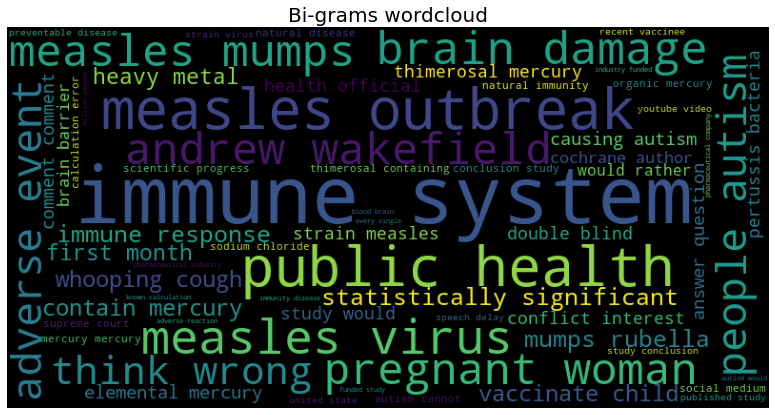

In [26]:
# Create a wordcloud for the most frequent bigrams.
wordcloud_title = WordCloud(width=800,
                            height=400,
                            stopwords=STOPWORDS)\
                            .generate_from_frequencies(bigram_freq)

# Plot bigrams wordclowd.
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud_title)
plt.axis('off')
plt.title('Bi-grams wordcloud', size=20)
plt.show()

The bigram wordcloud supports the previously identified myths.

## Topic modelling

Let us try to find other potential myths through topic modelling. For this purpose, we will use the most popular topic modelling algorithm: Latent Dirichlet Allocation.

In [27]:
# Get word lists from the given documents.
data_words = list(sent_to_words(docs))

# Build the bi-gram and tri-gram models.
bigram = Phrases(data_words, min_count=5, threshold=100)
trigram = Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram.
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# Tri-gram example.
print('Trigram model ex.: {}'.format(trigram_mod[bigram_mod[data_words[0]]]))

# Remove stop words.
data_words_nostops = remove_stopwords(data_words, stop_words)

# Form ti-grams.
data_words_bigrams = make_bigrams(data_words_nostops, bigram_mod)

# Form tri-grams.
data_words_trigrams = make_trigrams(data_words_nostops,
                                    bigram_mod,
                                    trigram_mod)

# Do lemmatization keeping only noun, adj, vb, adv.
data_lemmatized = lemmatization(data_words_bigrams,  allowed_postags=['NOUN'])

# Create dictionary.
id2word = Dictionary(data_lemmatized)

# Create corpus.
texts = data_lemmatized

# Term document frequency.
corpus = [id2word.doc2bow(text) for text in texts]

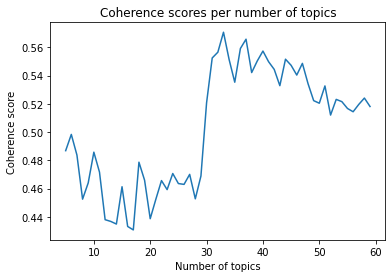

In [28]:
# Run several LDA Models for different k number of topics
# and plot their coherence scores.
coherence_scores = run_lda_models(corpus,
                                  id2word,
                                  data_lemmatized,
                                  min_topics_num=5,
                                  max_topics_num=60)

plt.plot(*zip(*coherence_scores))
plt.title('Coherence scores per number of topics')
plt.xlabel('Number of topics')
plt.ylabel('Coherence score')
plt.show()

In [29]:
print('Topics - Coherence:')
for el in coherence_scores:
    print('{} -- {}'.format(el[0], el[1]))

It is a good practice to pick the number of topics corresponding to the highest coherence score before the score starts flattening out, 33 in our case.

In [30]:
best_lda_model = LdaModel(corpus=corpus,
                          id2word=id2word,
                          num_topics=33,
                          random_state=100,
                          update_every=1,
                          chunksize=100,
                          passes=10,
                          alpha='auto',
                          eta='auto',
                          iterations=400,
                          per_word_topics=True)

# Print the keywords in the top 10 topics.
pprint(best_lda_model.print_topics())
doc_lda = best_lda_model[corpus]

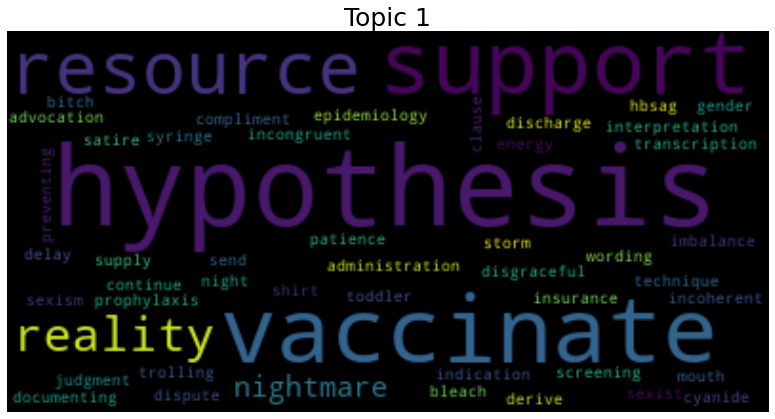

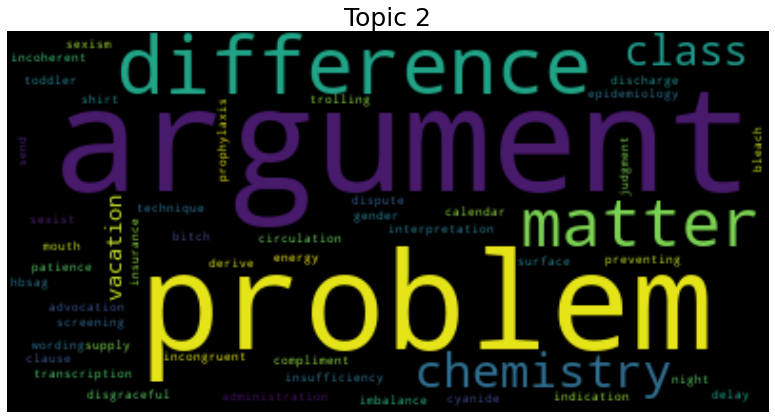

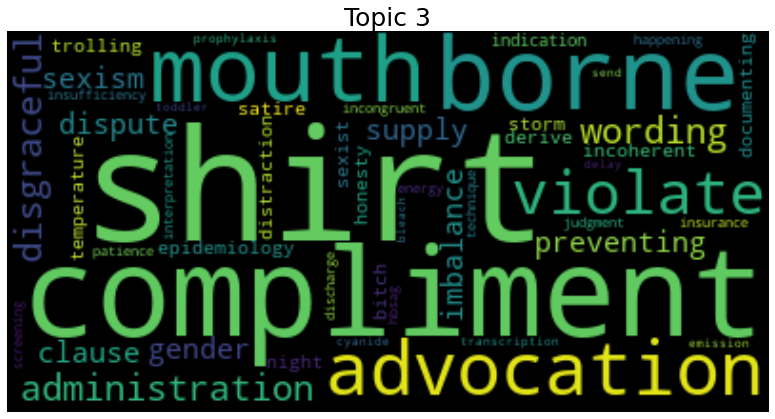

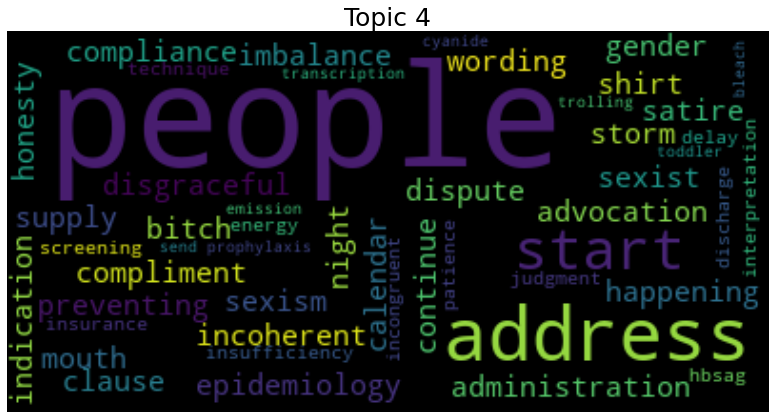

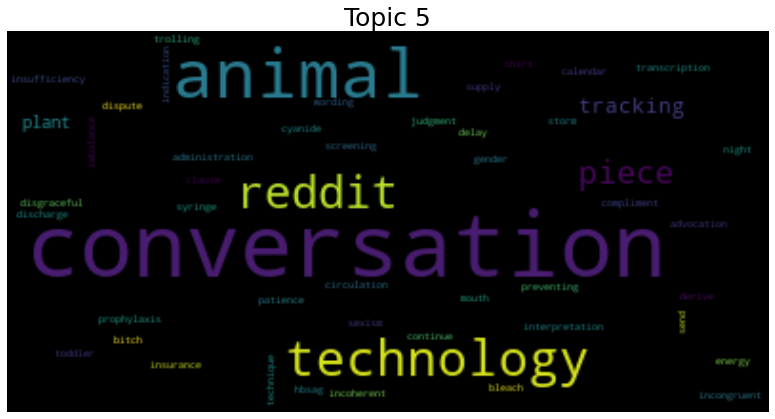

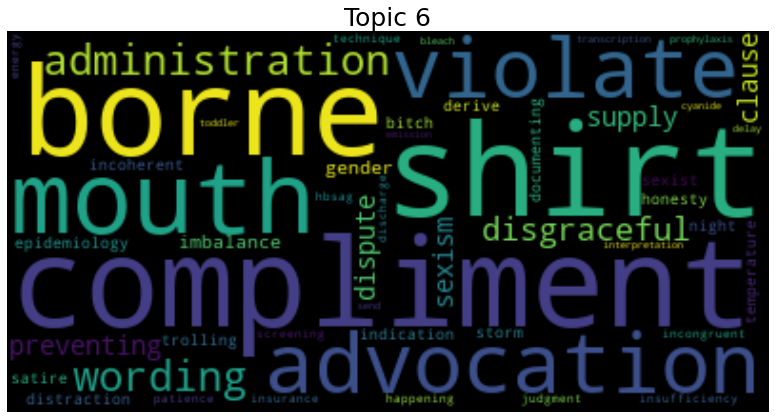

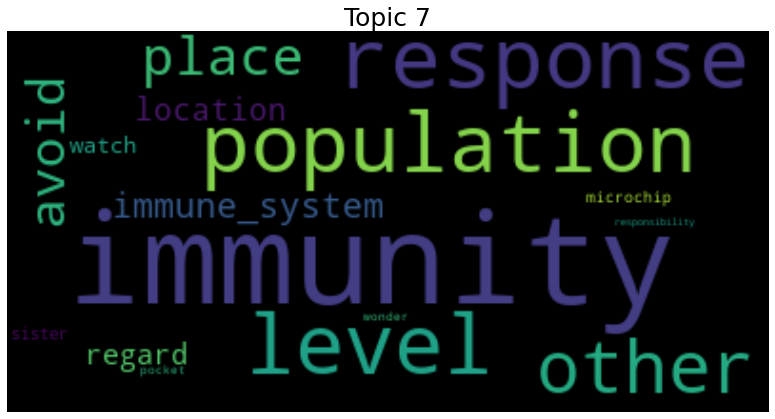

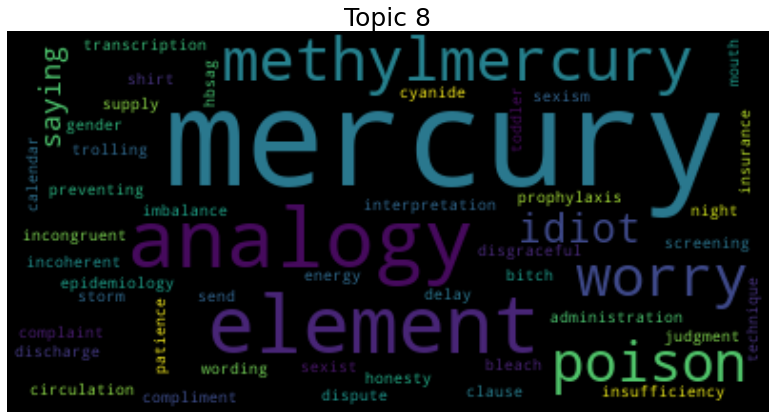

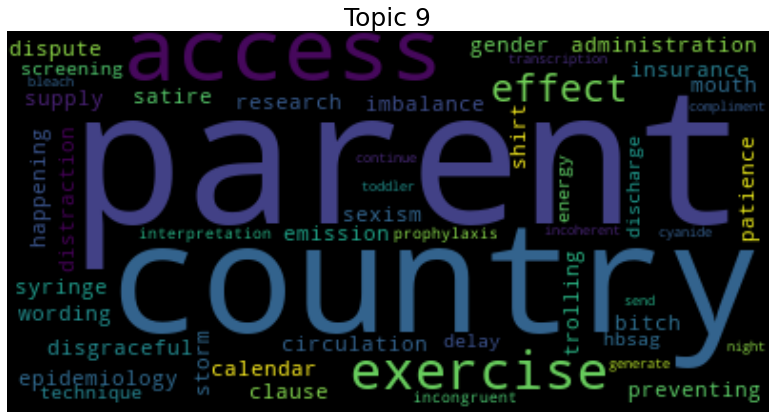

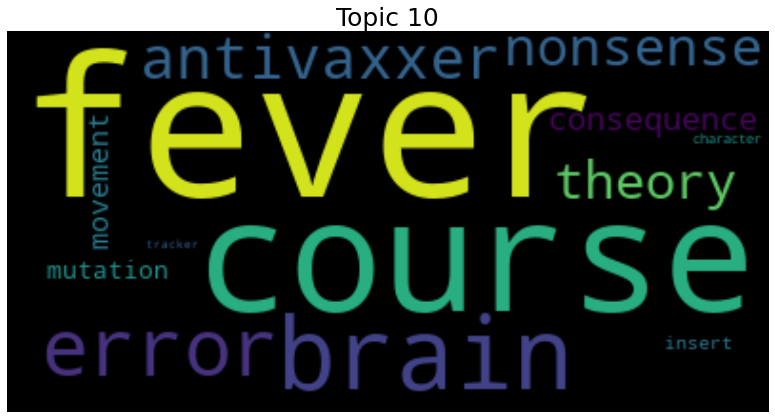

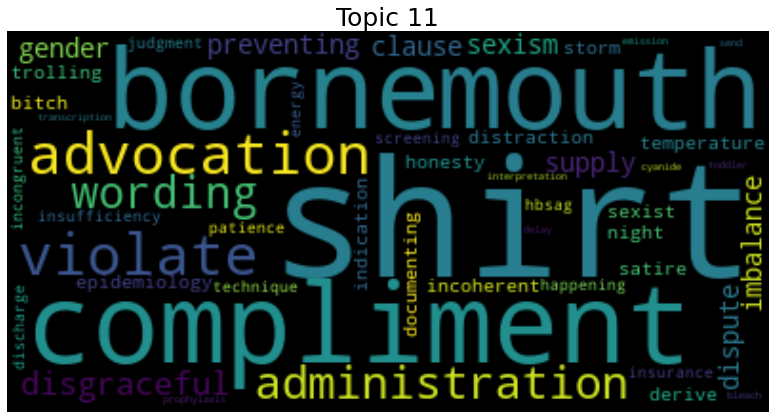

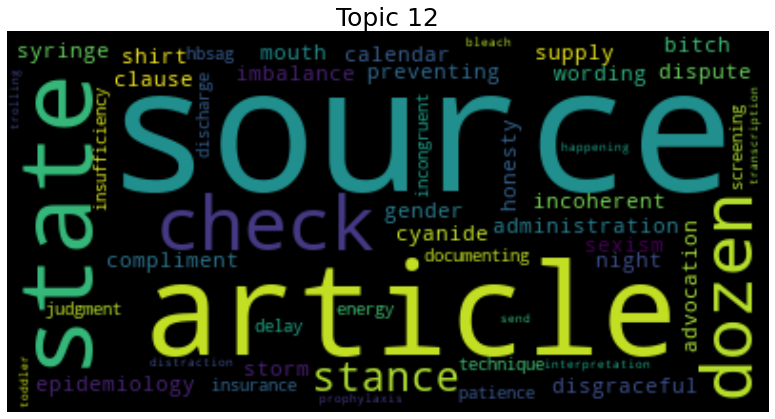

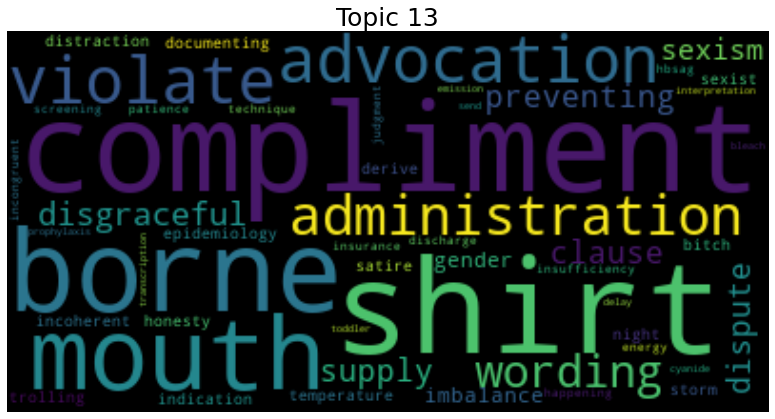

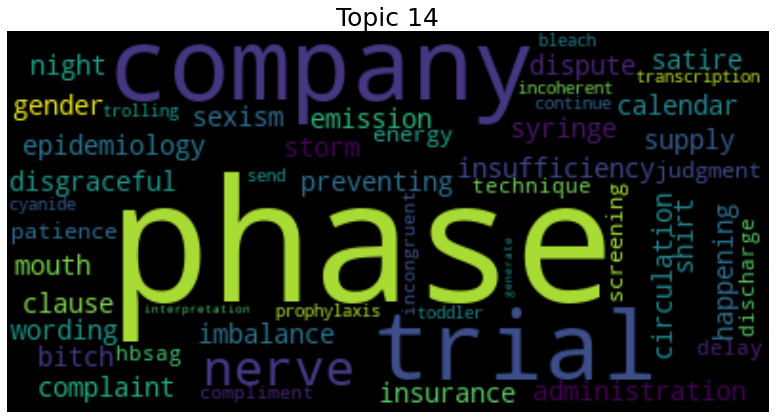

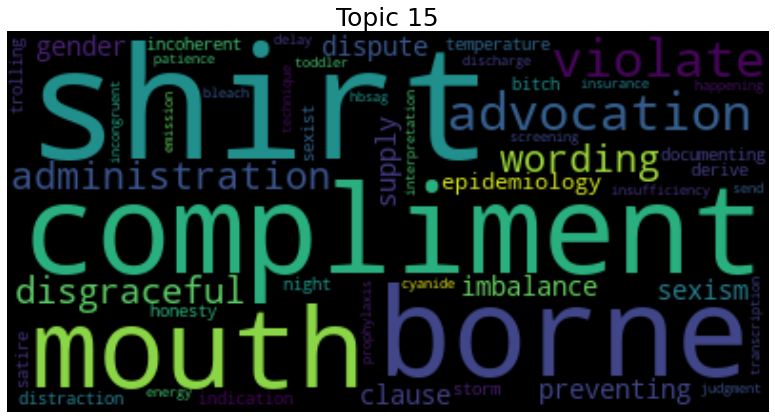

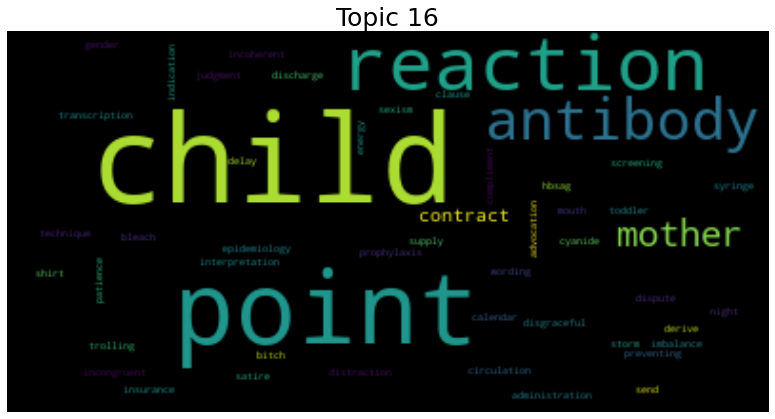

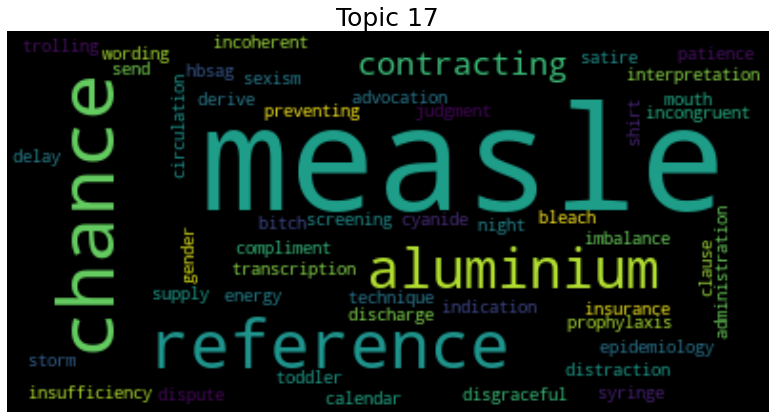

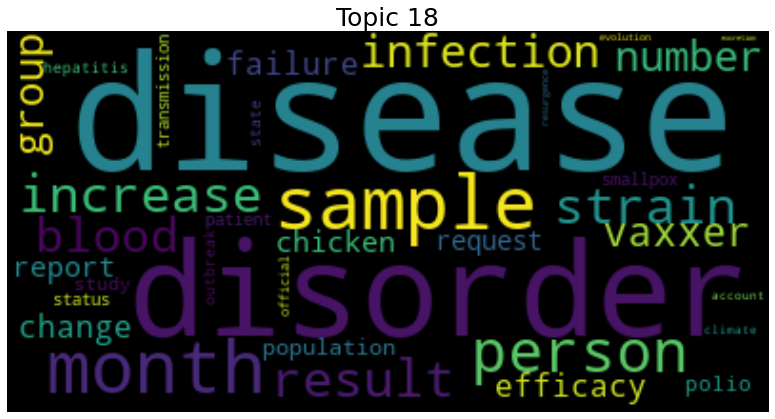

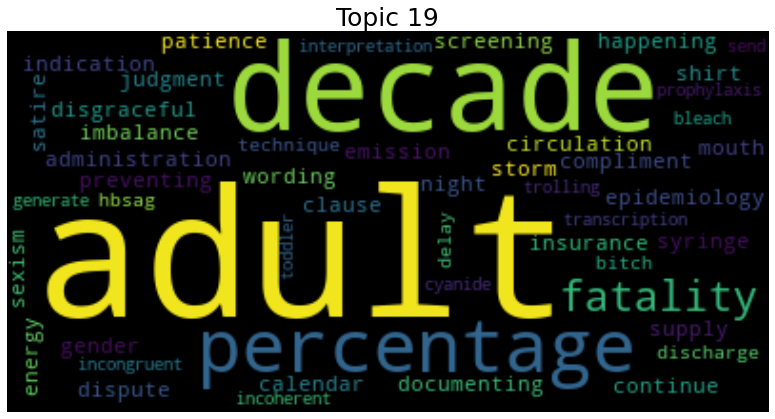

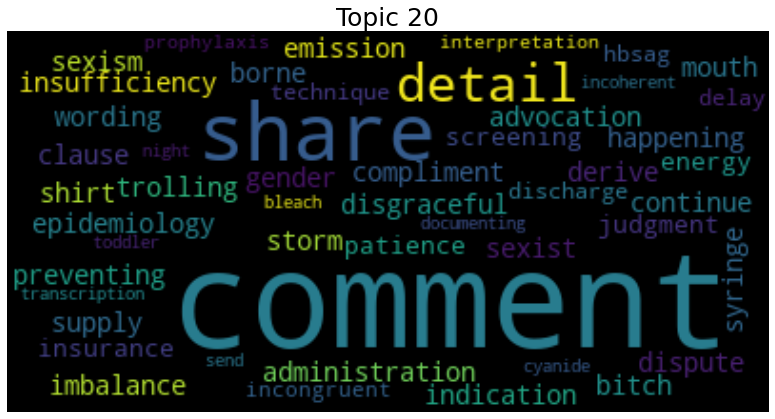

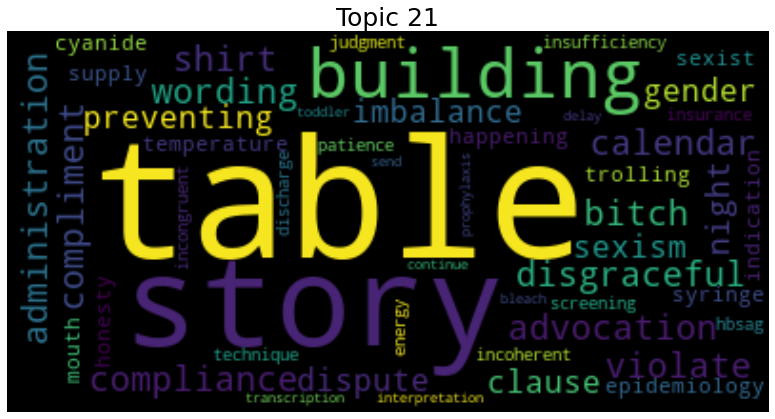

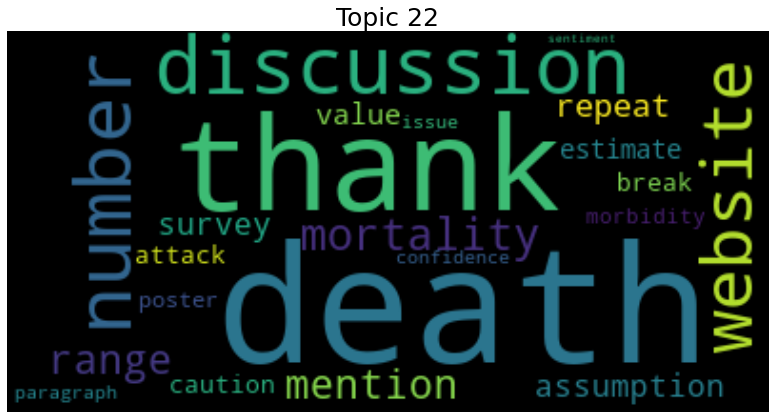

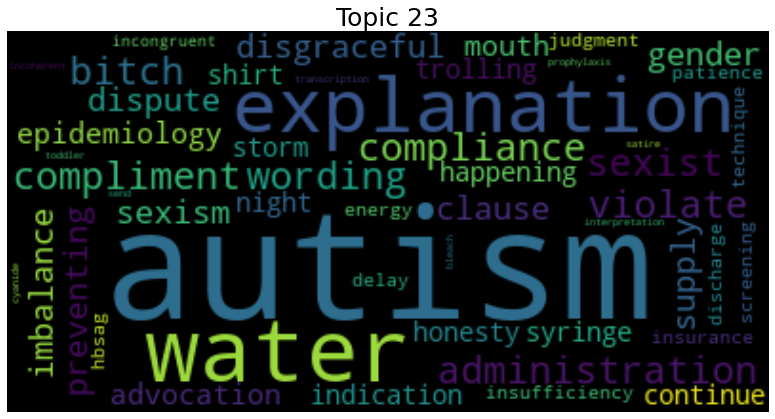

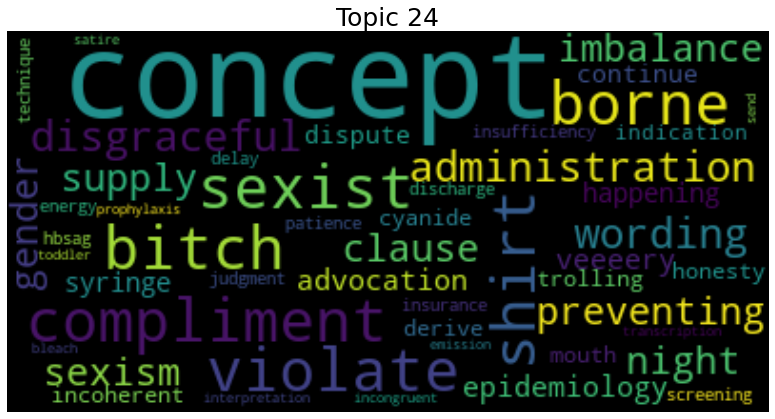

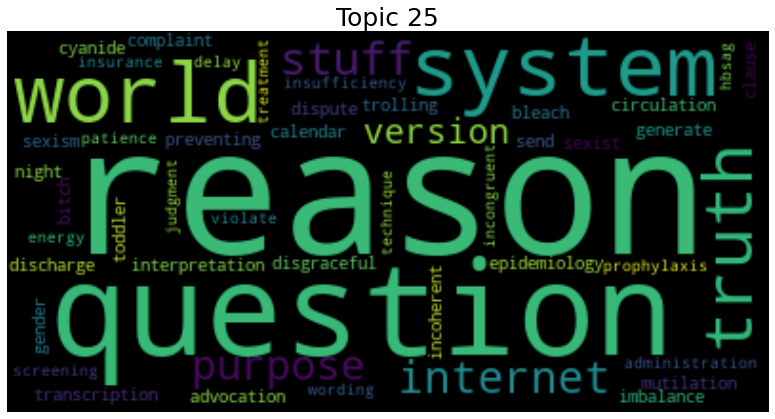

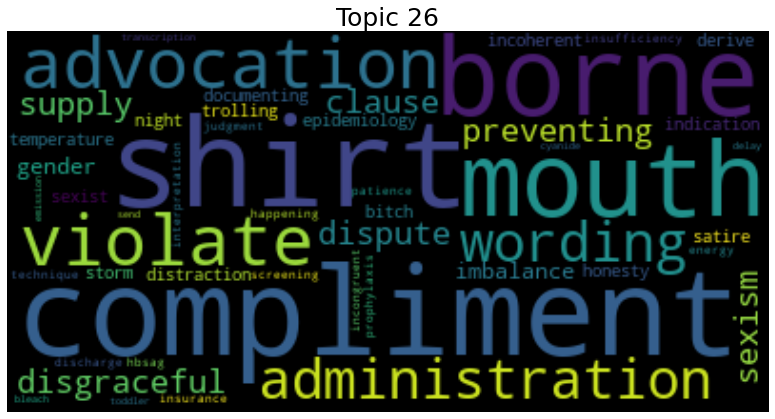

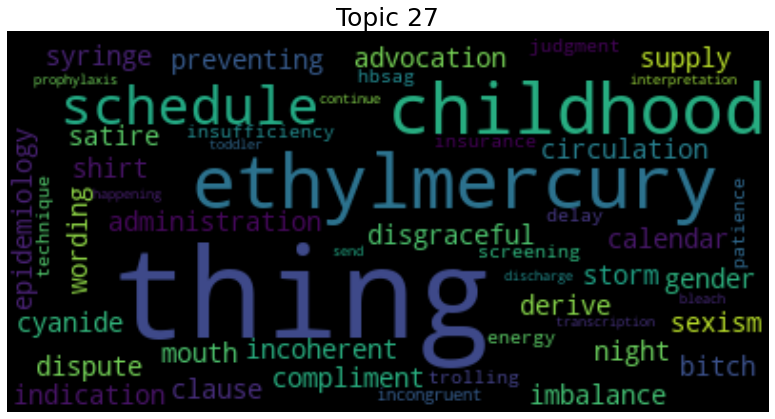

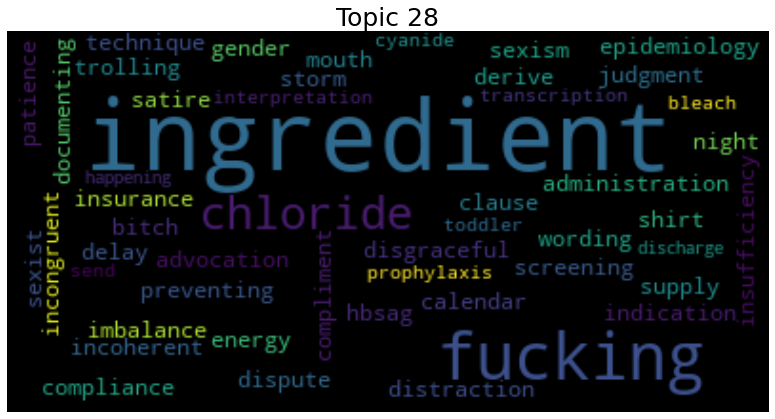

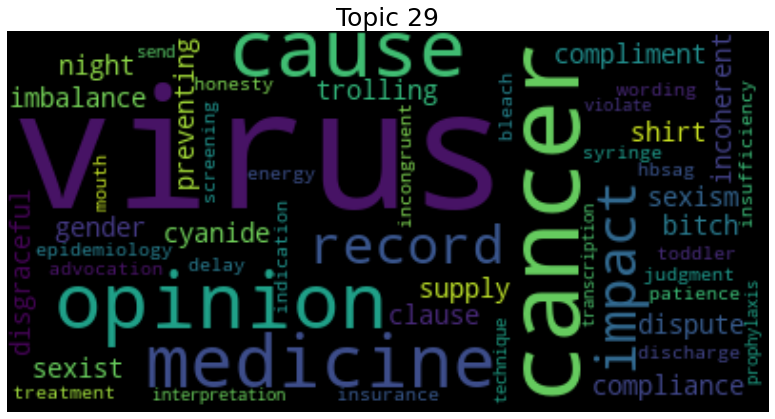

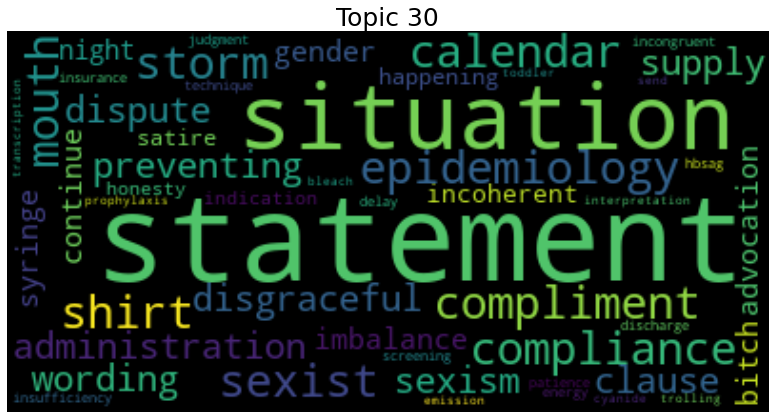

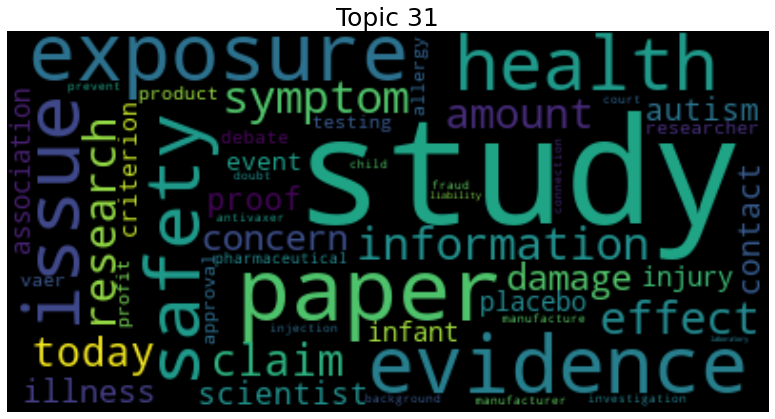

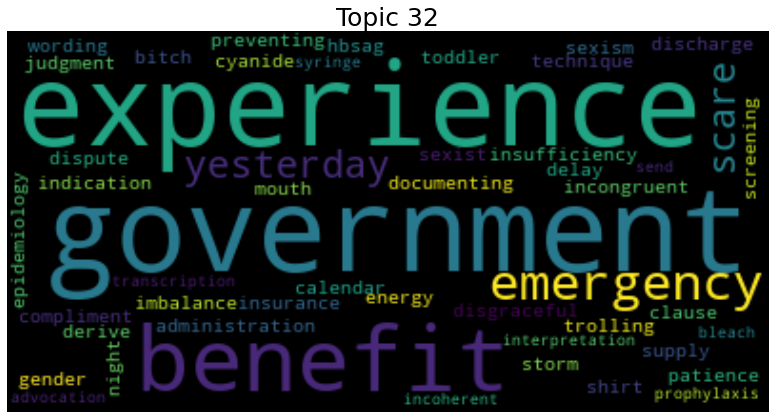

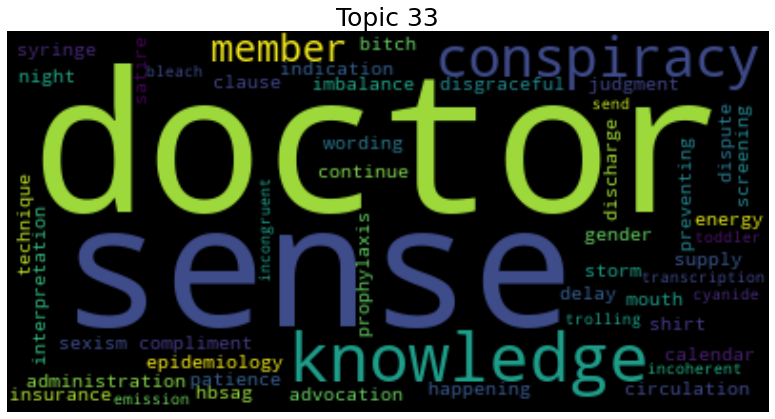

In [31]:
# Plot a wordcloud for each topic in the LDA Model.
plot_topics_wordclouds(best_lda_model, num_topics=33)

- Topic 10 illustrates the myth according to which vaccines can affect the brain as a consequence.  
- Topic 10 illustrates the myth according to which vaccines can cause strong immune reactions, especially harmful for children and pregnant women.  
- Topics 8, 27 and 28 illustrates the myth according to which vaccines contain mercury and other harmful substances, especially for children.  
- Topic 18 illustrates the myth according to which vaccines cause the actual disease.  
- Topic 22 illustrates the myth according to which vaccines can cause death.  
- Topic 23 illustrates the myth according to which vaccines cause autism.  
- Topic 29 illustrates the myth according to which vaccines can cause cancer.  

# Is the sentiment related to the score?

In [32]:
# Download the lexicon for VADER unsupervised
# sentiment analyzer.
nltk.download('vader_lexicon')

analyzer = SentimentIntensityAnalyzer()

# Compute and store the sentiment for each post/comment.
myths_df['sentiment'] = myths_df['full_text'].apply(
    lambda x: get_sentiment(x, analyzer)
    )

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/iuliana/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [33]:
myths_df.head()

title  score      id  \
0  Health Canada approves AstraZeneca COVID-19 va...      7  lt74vw   
1  COVID-19 in Canada: 'Vaccination passports' a ...      2  lsh0ij   
2  Coronavirus variants could fuel Canada's third...      6  lohlle   
3  Canadian government to extend COVID-19 emergen...      1  lnptv8   
4  Canada: Pfizer is 'extremely committed' to mee...      6  lkslm6   

                                                 url  comms_num       created  \
0  https://www.canadaforums.ca/2021/02/health-can...          0  1.614400e+09   
1  https://www.canadaforums.ca/2021/02/covid-19-i...          1  1.614316e+09   
2  https://www.canadaforums.ca/2021/02/coronaviru...          0  1.613887e+09   
3  https://www.canadaforums.ca/2021/02/canadian-g...          0  1.613796e+09   
4  https://www.canadaforums.ca/2021/02/canada-pfi...          0  1.613468e+09   

  body           timestamp        date  year  \
0      2021-02-27 06:33:45  2021-02-27  2021   
1      2021-02-26 07:11:07  2021-02-26  2021   
2      2021-02-21 07:50:08  2021-02-21  2021   
3      2021-02-20 06:35:13  2021-02-20  2021   
4      2021-02-16 11:36:28  2021-02-16  2021   

                                           full_text  \
0  Health Canada approves AstraZeneca COVID-19 va...   
1  COVID-19 in Canada: 'Vaccination passports' a ...   
2  Coronavirus variants could fuel Canada's third...   
3  Canadian government to extend COVID-19 emergen...   
4  Canada: Pfizer is 'extremely committed' to mee...   

                                              tokens sentiment  
0     [health, canada, approves, astrazeneca, covid]  positive  
1     [covid, canada, passport, certainty, ethicist]  positive  
2       [coronavirus, variant, could, canada, third]   neutral  
3  [canadian, government, extend, covid, emergenc...  positive  
4  [canada, pfizer, extremely, committed, meeting...  positive

Text(0.5, 1.0, 'Reddit scores distributions')

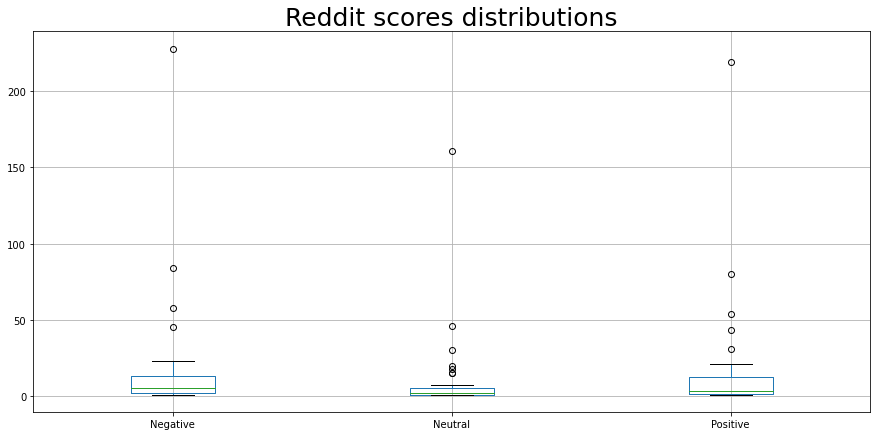

In [34]:
# Plot boxplots for the score distributions per sentiment.
ax = (myths_df.groupby(['score', 'sentiment']).size().to_frame('size')
      .unstack('sentiment').boxplot(figsize=(15, 7)))

ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
plt.title('Reddit scores distributions', size=25)

The box plots suggest that whereas the distributions of the scores for negative and positive sentiment posts/comments are very similar, the distribution of the score for neutral posts/comments has less spread, with values and median closer to 0. This suggests the hypothesis that neutral sentiment posts/comments do not trigger the users and obtain less reactions overall. On the other hand, more polarized sentiments trigger an emotional respose in users which feel more inclined to react.

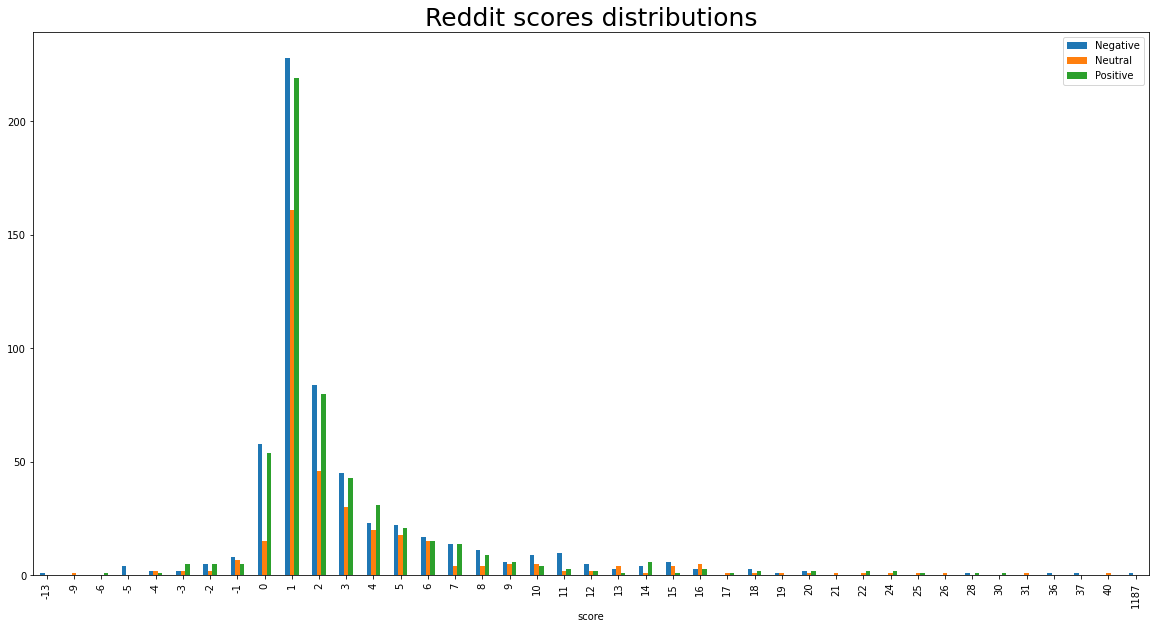

In [35]:
# Plot barplots for the score distributions per sentiment.
(myths_df.groupby(['score', 'sentiment']).size().to_frame('size')
 .unstack('sentiment').plot.bar(figsize=(20, 10)))

plt.title('Reddit scores distributions', size=25)
plt.legend(['Negative', 'Neutral', 'Positive'])

We need to test the aforementioned hypothesis through an appropriate statistical test. Since our dependent variable is numeric and our independent variable is categorical with 3 levels, a first test that could be performed is One-way ANOVA. However, this test requires certain assumptions to hold e.g.the dependent variable (scores here) approximates a multivariate normal distribution. This assumption needs to be verified prior to performing the test. Given that we have a distribution of scores, it is most likely not normal.

<Figure size 1440x720 with 0 Axes>

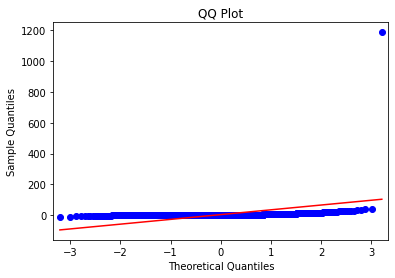

In [36]:
# Plot qq plot of the score to see
# if they are normally distributed.
plt.figure(figsize=(20, 10))
qqplot(myths_df['score'], line='s')
plt.title('QQ Plot')
plt.show()

The QQ plot reveals that the scores are not normally distributed. Let us also perform a shapiro test for normality.

In [37]:
# Shapiro normality test.
stat, p = shapiro(myths_df['score'])

print('Statistics=%.3f, p=%.3f' % (stat, p))

# If the test is significant, reject the null.
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    print('Sample does not look Gaussian (reject H0)')

The test confirmed that the scores are not aproximately normal. For this reason, we will use an equivalent parametric test instead to test our hypothesis: Kruskal-Wallis H-test.

In [38]:
# Kruskal-Wallis H-test.
pos_scores = myths_df[myths_df['sentiment'] == 'positive']['score']
neg_scores = myths_df[myths_df['sentiment'] == 'negative']['score']
neu_scores = myths_df[myths_df['sentiment'] == 'neutral']['score']

stat, p = kruskal(pos_scores, neg_scores, neu_scores)

print('Statistics=%.3f, p=%.3f' % (stat, p))

# If the test is significant, reject the null.
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

The test confirms our suspicions. The scores have different distributions per sentiment.

In [39]:
stat, p = kruskal(pos_scores, neg_scores)

print('Statistics=%.3f, p=%.3f' % (stat, p))

# If the test is significant, reject the null.
alpha = 0.05
if p > alpha:
    print('Same distributions (fail to reject H0)')
else:
    print('Different distributions (reject H0)')

If we perform the test again on only for negative and positive sentiment score, we can see that they have the same distributionts. Thus, the conclusion we arrive at is that indeed neutral sentiment posts/comments have different scores (closer to 0, less spread) than more polarized sentiments as they do not create the necessary emotional response in the usert to nudge them to react.